### Automatic Control Variates for Option Pricing using Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Matrix

print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

False
cpu


In [2]:
def printResults(basket_call, asian_option, digital_option, worst_of_put):
    print(f"Monte Carlo price pour Basket Call Option: {calcul_IC(basket_call)[0]:.2f} "
          f"({calcul_IC(basket_call)[1]:.2f}, "
          f"{calcul_IC(basket_call)[2]:.2f})")
    
    print(f"Monte Carlo price pour Asian Option: {calcul_IC(asian_option)[0]:.2f} "
          f"({calcul_IC(asian_option)[1]:.2f}, "
          f"{calcul_IC(asian_option)[2]:.2f})")
    
    print(f"Monte Carlo price pour Digital Option: {calcul_IC(digital_option)[0]:.2f} "
          f"({calcul_IC(digital_option)[1]:.2f}, "
          f"{calcul_IC(digital_option)[2]:.2f})")
    
    print(f"Monte Carlo price pour Worst Of Put Option: {calcul_IC(worst_of_put)[0]:.2f} "
          f"({calcul_IC(worst_of_put)[1]:.2f}, "
          f"{calcul_IC(worst_of_put)[2]:.2f})")

# Parameters
S0 = 100.0
K = 100.0
T = torch.tensor(1.0)
r = torch.tensor(0.05)
sigma = 0.4
rho = 0.75
d = 10
nb_trajectoires = 30_000
nb_steps = 100
nbsj = 10
weights = 1/d
G = 100

#for heston model
kappa = 2.0
sigma_0 = 0.04
a = 0.04
nu = 0.01
gamma = torch.tensor(-0.2)

### Payoffs

In [3]:
def basket_call_payoff(S, weights, K):
  valeur_basket = torch.sum(weights* S[:, -1, :], dim=1)
  return torch.exp(-r*T)*torch.maximum(valeur_basket - K, torch.tensor(0.0))

def digital_option_payoff(S, weights, K):
  valeur_digitale = torch.sum(weights * S[:, -1, :], dim=1)
  return torch.exp(-r*T)*torch.where(valeur_digitale >= K, torch.tensor(1.0), torch.tensor(0.0)) * torch.tensor(G)

def asian_option_payoff(S, weights, K):
  asian_average = torch.mean(torch.sum(weights * S, axis=-1), axis=-1)
  return torch.maximum(asian_average - K, torch.tensor(0.0))*torch.exp(-r*T)

def worst_of_put_payoff(S, weights, K):
  valeur_worst = torch.min(S[:, -1, :], dim=1).values
  return torch.exp(-r*T)*torch.maximum(K - valeur_worst, torch.tensor(0.0))

### Black Scholes Model

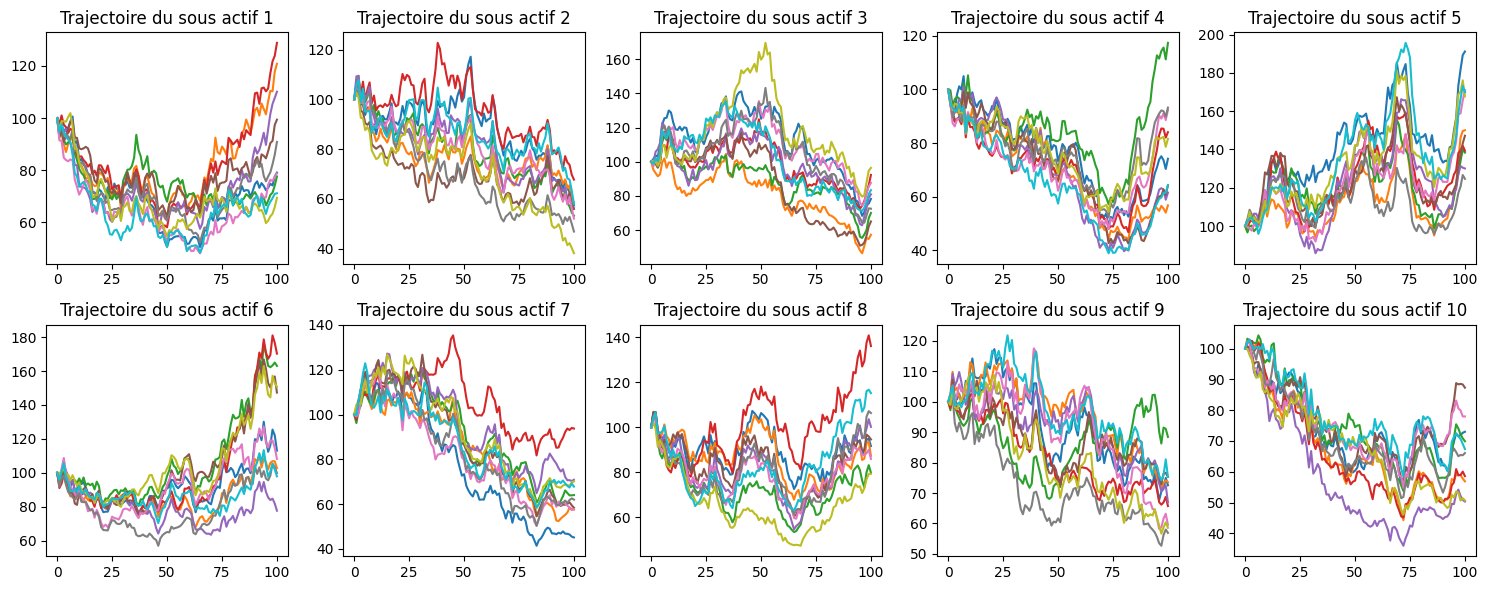

Monte Carlo price pour Basket Call Option: 16.33 (16.02, 16.63)
Monte Carlo price pour Asian Option: 9.07 (8.91, 9.23)
Monte Carlo price pour Digital Option: 46.54 (46.00, 47.08)
Monte Carlo price pour Worst Of Put Option: 26.46 (26.24, 26.68)


In [4]:
def black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps
    Sigma = torch.full((d, d), rho) + (1 - rho) * torch.eye(d) #Matrice de corrélation
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', Z, L.T)
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    for i in range(1, nb_steps + 1):
        S[:, i, :] = S[:, i-1, :]*torch.exp((r - 0.5 * sigma**2) * dt + torch.sqrt(dt) * sigma * dW[:,i-1,:])
    return S

S = black_scholes_model(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, torch.randn(nb_trajectoires, nb_steps+1, d))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

#On stocke les payoff de chaque option
basket_call = basket_call_payoff(S, weights, K)
asian_option = asian_option_payoff(S, weights, K)
digital_option = digital_option_payoff(S, weights, K)
worst_of_put = worst_of_put_payoff(S, weights, K)

def calcul_IC(prices):
    mean_price = torch.mean(prices)
    std_dev = torch.std(prices)
    n = len(prices)
    lower_bound = mean_price - 1.96 * (std_dev / np.sqrt(n))
    upper_bound = mean_price + 1.96 * (std_dev / np.sqrt(n))

    return mean_price, lower_bound, upper_bound

printResults(basket_call, asian_option, digital_option, worst_of_put)

### Local volatility Model

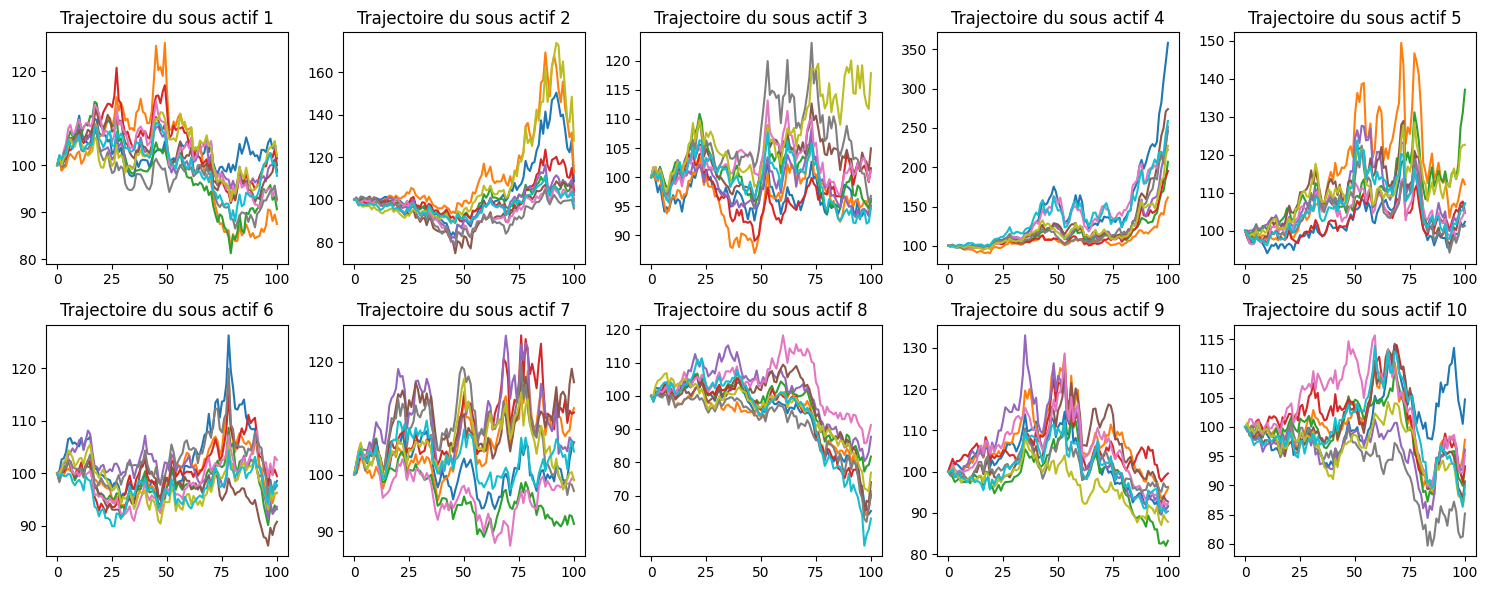

Monte Carlo price pour Basket Call Option: 8.84 (8.61, 9.06)
Monte Carlo price pour Asian Option: 4.23 (4.14, 4.32)
Monte Carlo price pour Digital Option: 49.05 (48.52, 49.59)
Monte Carlo price pour Worst Of Put Option: 10.76 (10.62, 10.90)


In [5]:
def volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps
    Sigma = torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Sigma)
    dW = torch.einsum('ijk,kl->ijl', Z, L.T)
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    
    for i in range(1, nb_steps + 1):
        t = i * dt
        vol_locale = 0.6 * (1.2 - torch.exp(-0.1 * t) * torch.exp(-0.001 * (S[:, i-1, :] * \
                            torch.exp(r*t) - S0)**2))* torch.exp(-0.05 * torch.sqrt(t))
        
        dSi = r * S[:, i-1, :] * dt + torch.sqrt(dt) * vol_locale * S[:, i-1, :] * dW[:, i-1, :]
        S[:, i, :] = S[:, i-1, :] + dSi
    return S

S_volatilite_locale = volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, 
                                        nb_steps, d, rho, torch.randn(nb_trajectoires, nb_steps+1, d))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S_volatilite_locale[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

# Prix des différentes options avec volatilité locale
basket_call_vol = basket_call_payoff(S_volatilite_locale, weights, K)
asian_option_vol = asian_option_payoff(S_volatilite_locale, weights, K)
digital_option_vol = digital_option_payoff(S_volatilite_locale, weights, K)
worst_of_put_vol = worst_of_put_payoff(S_volatilite_locale, weights, K)
# Affichage des résultats avec intervalles de confiance de 95%

printResults(basket_call_vol, asian_option_vol, digital_option_vol, worst_of_put_vol)

### Heston Model

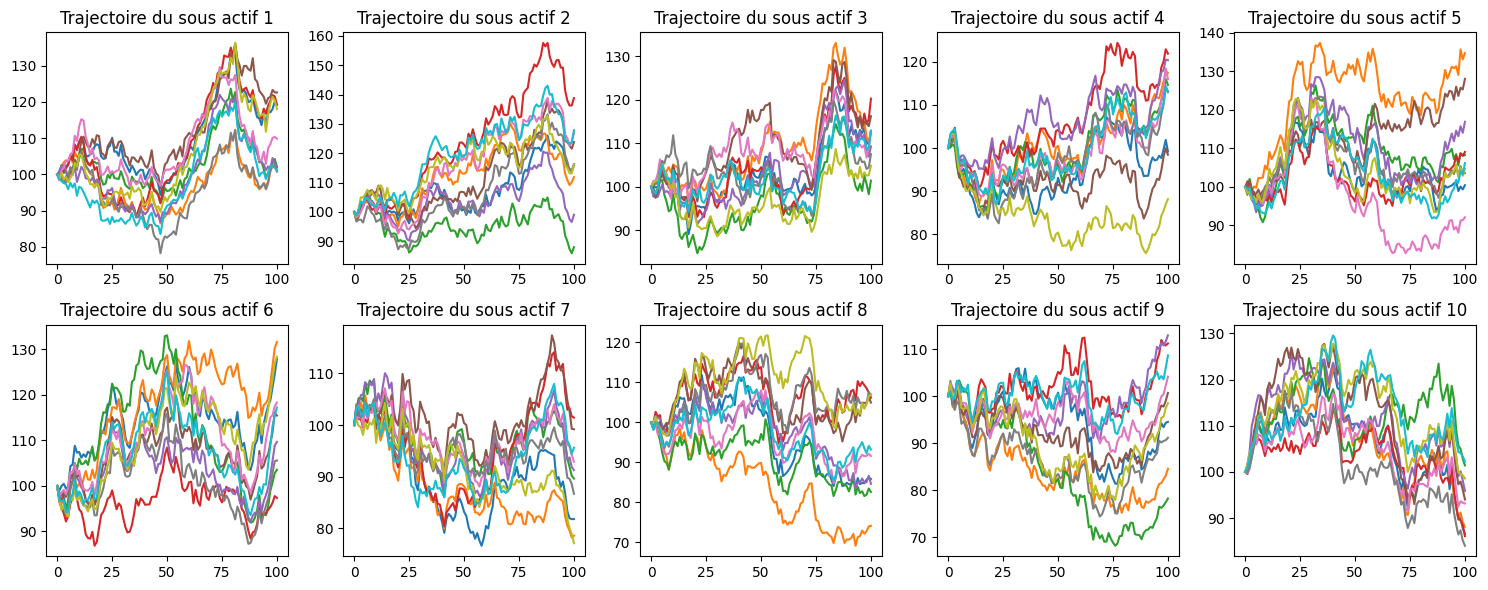

Monte Carlo price pour Basket Call Option: 9.48 (9.33, 9.62)
Monte Carlo price pour Asian Option: 5.16 (5.09, 5.24)
Monte Carlo price pour Digital Option: 54.74 (54.21, 55.28)
Monte Carlo price pour Worst Of Put Option: 12.56 (12.43, 12.69)


In [6]:
def heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, Z):
    dt = T / nb_steps

    Sigma= torch.full((d, d), rho) + (1 - rho) * torch.eye(d)
    L = torch.linalg.cholesky(Sigma)
    
    dB = torch.einsum('ijk,kl->ijl', torch.randn(Z.shape[0], Z.shape[1], Z.shape[2]), L.T)
    dB_tilde = torch.randn(Z.shape[0], Z.shape[1], Z.shape[2])
    
    S = torch.zeros((Z.shape[0], Z.shape[1], Z.shape[2]))
    S[:, 0, :] =  S0
    sigma = torch.ones((Z.shape[0], Z.shape[1], Z.shape[2])) * sigma_0
    # Calculer les trajectoires du modèle Heston
    for i in range(1, nb_steps + 1):
        dSi = r * S[:, i-1, :] * dt + torch.sqrt(sigma[:, i-1, :]) * S[:, i-1, :] * torch.sqrt(dt) * dB[:, i-1, :]
        dSigma_i = kappa * (a - sigma[:, i-1, :]) * dt + \
                    nu * torch.sqrt(sigma[:, i-1, :]) * \
                    (gamma * torch.sqrt(dt) * dB[:, i-1, :] + torch.sqrt(1 - gamma**2) * torch.sqrt(dt) * dB_tilde[:, i-1, :])
        S[:, i, :] = S[:, i-1, :] + dSi
        sigma[:, i, :] = sigma[:, i-1, :] + dSigma_i
    return S

#Modele d'Heston

# MC Heston
S_heston = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, 
                        nb_steps, d, rho, torch.randn(nb_trajectoires, nb_steps+1, d))

# Payoff
basket_call_heston = basket_call_payoff(S_heston, weights, K)
asian_option_heston = asian_option_payoff(S_heston, weights, K)
digital_option_heston = digital_option_payoff(S_heston, weights, K)
worst_of_put_heston = worst_of_put_payoff(S_heston, weights, K)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

#On trace les différentes trajectoires du marché
for i, ax in enumerate(axes.flatten()):
    if i < nb_trajectoires:
        ax.plot(S_heston[i, :, :])
        ax.set_title(f'Trajectoire du sous actif {i + 1}')

plt.tight_layout()
plt.show()

printResults(basket_call_heston, asian_option_heston, digital_option_heston, worst_of_put_heston)

### First Approach Control variates

In [7]:
## Hyperparameters

hyperparameters = {"perc_train_set" : 0.8, "input_size" : (nb_steps+1)*d
                              , "hidden_size" : 64, "output_size" : 1, "batch_size" : 32
                             , "nb_epochs" : 32, "lr" : 0.001}

In [8]:
# Création de 4 instances de chaque modèle

# Définition de la classe du réseau de neurones avec intégration analytique

class NeuralNetwork_Analytic_Integration(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(NeuralNetwork_Analytic_Integration, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Noms des modèles pour les différentes diffusions

model_bs_names = ["model_bs_basket_call", "model_bs_digital_option", 
                  "model_bs_worst_of_put", "model_bs_asian_option",]

model_vol_names = ["model_vol_basket_call", "model_vol_digital_option", 
                   "model_vol_worst_of_put", "model_vol_asian_option"]
    
model_heston_names = ["model_heston_basket_call", "model_heston_digital_option", 
                      "model_heston_worst_of_put", "model_heston_asian_option"]

# Initialisation des dictionnaires pour stocker les instances des modèles

model_bs = {}
model_vol = {}
model_heston = {}

# Création des instances des modèles pour chaque diffusion

for name in model_bs_names:
    model_bs[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)
for name in model_vol_names:
    model_vol[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)
for name in model_heston_names:
    model_heston[name]= NeuralNetwork_Analytic_Integration(hyperparameters['input_size'], 
                                                    hyperparameters['hidden_size'], hyperparameters['output_size']).to(device)

In [9]:
def train(list_model, diffusion_model, X, hyperparameters): 
    # Extraction des hyperparamètres
    perc_train_set = hyperparameters["perc_train_set"]
    prop_train_set = int(perc_train_set*nb_trajectoires)
    nb_epochs = hyperparameters["nb_epochs"]
    batch_size = hyperparameters["batch_size"]
    lr = hyperparameters["lr"]

    # Génération des trajectoires de prix selon le modèle de diffusion
    if diffusion_model == 'bs':
        S = black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X)
    elif diffusion_model == 'loc_vol':
        S = volatilite_locale(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X)
    else:
        S = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, X)

    # Division des données en ensembles d'entraînement et de test
    X_train = X[:prop_train_set, :, :]
    X_test = X[prop_train_set:, :, :]

    # Entraînement de chaque modèle dans la liste
    for (i,model) in enumerate(list_model_bs):
        if i == 0:
            y = basket_call_payoff(S, weights, K)
        elif i == 1:
            y = digital_option_payoff(S, weights, K)
        elif i == 2:
            y = worst_of_put_payoff(S, weights, K)
        else:
            y = asian_option_payoff(S, weights, K)

        y_train = y[:prop_train_set]
        y_test = y[prop_train_set:]

        # Remodelage des données d'entrée et de sortie
        X_train = X_train.view(X_train.shape[0], -1)
        X_test = X_test.view(X_test.shape[0], -1)
        y_train = y_train.view(y_train.shape[0], 1)
        y_test = y_test.view(y_test.shape[0], 1)

        # Création des ensembles de données et des chargeurs de données PyTorch (pour le batchsize)
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

        # Définition de l'optimiseur et de la fonction de perte qui étaient imposés
        optimizer = torch.optim.Adam(model.parameters(), lr)
        criterion = torch.nn.MSELoss()

        # Listes pour stocker les pertes d'entraînement et de test
        train_loss = []
        test_loss = []

        # Boucle d'entraînement
        for epoch in tqdm(range(nb_epochs)):
            model.train()
            train_losses = []
            
            for inputs, targets in train_loader:
                #inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
    
            train_loss.append(sum(train_losses) / len(train_losses))

            # Évaluation sur l'ensemble de test toutes les 10 époques
            if epoch % 10 == 0:
                model.eval()
                test_losses = []
               
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        #inputs, targets = inputs.to(device), targets.to(device) #for gpu
                        outputs = model(inputs)
                        loss_test = criterion(outputs, targets)
                        test_losses.append(loss_test.item())
                        
                test_loss.append(sum(test_losses) / len(test_losses))
                print(f"Epoch: {epoch} | Train Loss: {train_loss[-1]} | Test Loss: {test_loss[-1]}")

        # Fonction de la perte de test pour chaque modèle
        plt.plot(range(len(test_loss)),test_loss, label=f'Modèle {i}')

  3%|██▌                                                                                | 1/32 [00:02<01:22,  2.65s/it]

Epoch: 0 | Train Loss: 338.20582091267903 | Test Loss: 50.155040593857464


 34%|████████████████████████████▏                                                     | 11/32 [00:26<00:51,  2.47s/it]

Epoch: 10 | Train Loss: 5.362771032015482 | Test Loss: 9.714877677090625


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:57<00:33,  3.07s/it]

Epoch: 20 | Train Loss: 2.4392944655418396 | Test Loss: 9.033259328375472


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:24<00:02,  2.64s/it]

Epoch: 30 | Train Loss: 1.8561265908082327 | Test Loss: 7.713834715650437


  3%|██▌                                                                                | 1/32 [00:02<01:22,  2.68s/it]

Epoch: 0 | Train Loss: 2151.524673502604 | Test Loss: 995.1415986406042


 34%|████████████████████████████▏                                                     | 11/32 [00:28<00:53,  2.55s/it]

Epoch: 10 | Train Loss: 596.3738483072917 | Test Loss: 1013.399241021339


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:52<00:27,  2.53s/it]

Epoch: 20 | Train Loss: 360.782583597819 | Test Loss: 1116.9082992229055


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:21<00:02,  2.94s/it]

Epoch: 30 | Train Loss: 168.73664893595378 | Test Loss: 1209.680445894282


  3%|██▌                                                                                | 1/32 [00:02<01:25,  2.76s/it]

Epoch: 0 | Train Loss: 340.790544728597 | Test Loss: 66.17789713879849


 34%|████████████████████████████▏                                                     | 11/32 [00:31<00:58,  2.79s/it]

Epoch: 10 | Train Loss: 22.026827709198 | Test Loss: 67.71560409221243


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:57<00:29,  2.68s/it]

Epoch: 20 | Train Loss: 7.126304481347402 | Test Loss: 75.82127303265511


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:24<00:02,  2.78s/it]

Epoch: 30 | Train Loss: 2.909579688866933 | Test Loss: 78.56407676859105


  3%|██▌                                                                                | 1/32 [00:02<01:30,  2.92s/it]

Epoch: 0 | Train Loss: 70.12878806845347 | Test Loss: 6.496792217518421


 34%|████████████████████████████▏                                                     | 11/32 [00:31<01:01,  2.93s/it]

Epoch: 10 | Train Loss: 1.4934985627333324 | Test Loss: 2.3665163463100476


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:58<00:27,  2.52s/it]

Epoch: 20 | Train Loss: 0.7649236453970273 | Test Loss: 1.7799491191163976


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:22<00:02,  2.50s/it]

Epoch: 30 | Train Loss: 0.5028616684873899 | Test Loss: 1.5688250191668247


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:25<00:00,  2.66s/it]


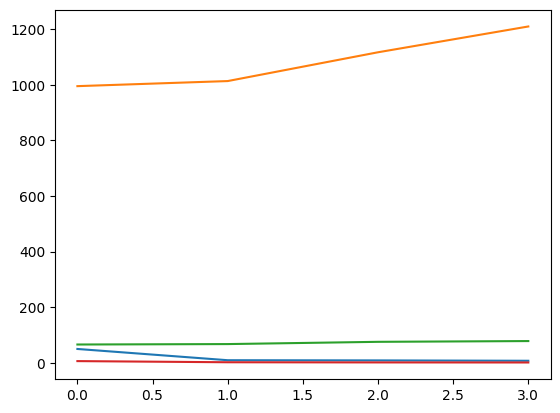

In [10]:
#Training for Black Scholes model, some overfitting 

model_bs_basket_call = model_bs["model_bs_basket_call"]
model_bs_digital_option = model_bs["model_bs_digital_option"]
model_bs_worst_of_put = model_bs["model_bs_worst_of_put"]
model_bs_asian_option = model_bs["model_bs_asian_option"]

list_model_bs = [model_bs_basket_call, model_bs_digital_option, 
                 model_bs_worst_of_put, model_bs_asian_option]

train(list_model_bs, 'bs', torch.randn(nb_trajectoires, nb_steps+1, d), hyperparameters)

In [11]:
def Analytic_integration(model):
    # Extraction des paramètres du modèle
    params = model.state_dict()
    W1 = params['layer1.weight']
    b1 = params['layer1.bias']
    W2 = params['layer2.weight']
    b2 = params['layer2.bias']

    # Calcul des paramètres de la distribution normale
    sigma = torch.sum(W1**2, dim=1)
    mu = b1
    cdf_result = torch.tensor(norm.cdf((-mu/(torch.sqrt(sigma))).cpu().numpy(), 0, 1)).to(device)

    # Calcul de l'expression de l'espérance
    expression = (torch.sqrt(sigma)) / (torch.sqrt(2 * torch.tensor(torch.pi))) * \
    torch.exp(- mu**2/ (2 * sigma)) + mu * (1 - cdf_result)

    expression = expression.unsqueeze(1)
    W2 = W2.to(expression.dtype)
    
    # Calcul de l'espérance
    esperance = torch.mm(W2, expression) + b2
    return esperance.to(device)

# Y = f(Z) - H(Z) +E[H(Z)], E[Y] = E[f(Z)]

def Y(model, diffusion_model, payoff,new_Z):
    liste = []
    model.eval()
    for i in range(500):
        Z_trajectory = new_Z[i,:,:]
        Z_trajectory = Z_trajectory.view(1,nb_steps+1,d)
        # Génération du processus stochastique en fonction du modèle de diffusion
        if diffusion_model == 'bs':
            random_S = black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
        elif diffusion_model == 'loc_vol':
            random_S = volatilite_locale(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)
        else:
            random_S = heston_model(S0 , K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, Z_trajectory)

        # Calcul du payoff
        f_Z = payoff(random_S, weights, K)
        Z_trajectory = Z_trajectory.flatten().reshape(1,-1)
        Z_trajectory = Z_trajectory.to(device)

        # Calcul de Y
        Y = f_Z - model(Z_trajectory).item() + Analytic_integration(model).item()
        liste.append(Y)
    print(np.mean(liste))

In [12]:
# Testons maintenant le réseau de neurones le model de Black Scholes
# Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = torch.randn(nb_trajectoires, nb_steps+1, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_bs.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 25616
Payoff Call Basket | output :  0.0
Payoff Digital Option | output :  0.0
Payoff Put Worst of max | output :  47.82716751098633
Payoff Arithmetic Asian | output :  0.0

Model model_bs_basket_call | output :  0.0697430670261383
Model model_bs_digital_option | output :  4.225727081298828
Model model_bs_worst_of_put | output :  61.56227111816406
Model model_bs_asian_option | output :  0.542816698551178


In [13]:
dic_model_bs_payoff = {model_bs_basket_call : basket_call_payoff, model_bs_digital_option : digital_option_payoff,
                     model_bs_worst_of_put : worst_of_put_payoff, model_bs_asian_option : asian_option_payoff}

new_Z = torch.randn(nb_trajectoires, nb_steps+1, d)
# Les prix obtenus sont ceux du tableau 2
for model,payoff in dic_model_bs_payoff.items():
  Y(model,'bs', payoff, new_Z)

16.077631
47.48738
27.577627
9.053924


  3%|██▌                                                                                | 1/32 [00:02<01:28,  2.85s/it]

Epoch: 0 | Train Loss: 85.21227473386129 | Test Loss: 76.58415728426993


 34%|████████████████████████████▏                                                     | 11/32 [00:27<00:51,  2.46s/it]

Epoch: 10 | Train Loss: 6.392504882494609 | Test Loss: 51.75133494747446


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:51<00:26,  2.42s/it]

Epoch: 20 | Train Loss: 3.911635699192683 | Test Loss: 51.034956592194575


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:16<00:02,  2.44s/it]

Epoch: 30 | Train Loss: 3.108618981162707 | Test Loss: 50.96524167821762


  3%|██▌                                                                                | 1/32 [00:02<01:18,  2.54s/it]

Epoch: 0 | Train Loss: 1274.0807243652343 | Test Loss: 1181.0913170347822


 34%|████████████████████████████▏                                                     | 11/32 [00:28<00:57,  2.73s/it]

Epoch: 10 | Train Loss: 231.41871447753905 | Test Loss: 1245.660321499439


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:54<00:27,  2.54s/it]

Epoch: 20 | Train Loss: 45.88746963882446 | Test Loss: 1373.6181958786985


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:24<00:02,  2.84s/it]

Epoch: 30 | Train Loss: 26.896952863057454 | Test Loss: 1412.8817372423537


  3%|██▌                                                                                | 1/32 [00:03<01:41,  3.28s/it]

Epoch: 0 | Train Loss: 54.012781155904136 | Test Loss: 30.295660353721455


 34%|████████████████████████████▏                                                     | 11/32 [00:34<01:06,  3.16s/it]

Epoch: 10 | Train Loss: 2.978779351393382 | Test Loss: 30.555673370970055


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:02<00:32,  2.92s/it]

Epoch: 20 | Train Loss: 1.1758792006174723 | Test Loss: 30.023952215275866


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:31<00:03,  3.08s/it]

Epoch: 30 | Train Loss: 0.8933520059982936 | Test Loss: 29.27412623547493


  3%|██▌                                                                                | 1/32 [00:04<02:15,  4.35s/it]

Epoch: 0 | Train Loss: 10.720907763282458 | Test Loss: 7.6169256418943405


 34%|████████████████████████████▏                                                     | 11/32 [00:32<01:00,  2.90s/it]

Epoch: 10 | Train Loss: 0.7736589560906092 | Test Loss: 5.633925561733703


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:02<00:34,  3.14s/it]

Epoch: 20 | Train Loss: 0.4740967799127102 | Test Loss: 5.442555256504962


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:26<00:02,  2.31s/it]

Epoch: 30 | Train Loss: 0.4199439046382904 | Test Loss: 5.712469745506632


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:29<00:00,  2.79s/it]


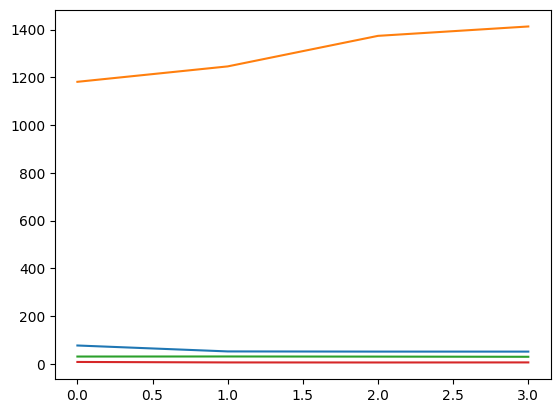

In [14]:
# Entrainement des modèles dont les actifs suivent le modèle vol locale

model_vol_basket_call = model_vol["model_vol_basket_call"]
model_vol_digital_option = model_vol["model_vol_digital_option"]
model_vol_worst_of_put = model_vol["model_vol_worst_of_put"]
model_vol_asian_option = model_vol["model_vol_asian_option"]

list_model_vol = [model_vol_basket_call, model_vol_digital_option, 
                  model_vol_worst_of_put, model_vol_asian_option]

train(list_model_vol, 'loc_vol', torch.randn(nb_trajectoires, nb_steps+1, d), hyperparameters)

In [15]:
#Testons maintenant la méthode 2 avec Black Scholes
#Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = torch.randn(nb_trajectoires, nb_steps+1, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = volatilite_locale(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_vol.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 28656
Payoff Call Basket | output :  0.0
Payoff Digital Option | output :  0.0
Payoff Put Worst of max | output :  17.718368530273438
Payoff Arithmetic Asian | output :  3.9504921436309814

Model model_vol_basket_call | output :  0.28978264331817627
Model model_vol_digital_option | output :  -0.4065234661102295
Model model_vol_worst_of_put | output :  0.1982141137123108
Model model_vol_asian_option | output :  0.02822805941104889


In [16]:
dic_model_vol_payoff = {model_vol_basket_call : basket_call_payoff, model_vol_digital_option : digital_option_payoff,
                     model_vol_worst_of_put : worst_of_put_payoff, model_vol_asian_option : asian_option_payoff}

#Entrainement des modèles dont les actifs suivent le modèle vol locale

new_Z = torch.randn(nb_trajectoires, nb_steps+1, d)
#Les prix obtenues sont ceux du tableau 2
for model,payoff in dic_model_vol_payoff.items():
  Y(model,'loc_vol', payoff,new_Z)

6.829744
46.22806
11.450268
3.2472413


  3%|██▌                                                                                | 1/32 [00:02<01:16,  2.47s/it]

Epoch: 0 | Train Loss: 257.99264616902667 | Test Loss: 199.86169360546356


 34%|████████████████████████████▏                                                     | 11/32 [00:27<00:51,  2.43s/it]

Epoch: 10 | Train Loss: 38.128444792429605 | Test Loss: 248.85888055030335


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:54<00:30,  2.75s/it]

Epoch: 20 | Train Loss: 11.711306579271952 | Test Loss: 288.0876995654816


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:21<00:02,  2.66s/it]

Epoch: 30 | Train Loss: 7.69357898012797 | Test Loss: 293.65431245844417


  3%|██▌                                                                                | 1/32 [00:02<01:18,  2.52s/it]

Epoch: 0 | Train Loss: 3295.3049010416667 | Test Loss: 2986.552286350981


 34%|████████████████████████████▏                                                     | 11/32 [00:29<01:03,  3.04s/it]

Epoch: 10 | Train Loss: 385.6146147664388 | Test Loss: 3133.2811616938166


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:59<00:30,  2.74s/it]

Epoch: 20 | Train Loss: 55.82035706837972 | Test Loss: 3589.764190024518


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:25<00:02,  2.61s/it]

Epoch: 30 | Train Loss: 49.092542649586996 | Test Loss: 3585.642807331491


  3%|██▌                                                                                | 1/32 [00:02<01:19,  2.56s/it]

Epoch: 0 | Train Loss: 193.82214482625326 | Test Loss: 166.37810918118092


 34%|████████████████████████████▏                                                     | 11/32 [00:29<00:55,  2.62s/it]

Epoch: 10 | Train Loss: 28.226243012746174 | Test Loss: 183.88609370779483


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [00:58<00:31,  2.84s/it]

Epoch: 20 | Train Loss: 3.8125104467074076 | Test Loss: 216.24999107198514


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:33<00:03,  3.72s/it]

Epoch: 30 | Train Loss: 3.131178098042806 | Test Loss: 211.55082499727288


  3%|██▌                                                                                | 1/32 [00:02<01:24,  2.74s/it]

Epoch: 0 | Train Loss: 61.178191504160566 | Test Loss: 55.55104076101425


 34%|████████████████████████████▏                                                     | 11/32 [00:33<01:08,  3.25s/it]

Epoch: 10 | Train Loss: 8.466190664609273 | Test Loss: 76.97550207503299


 66%|█████████████████████████████████████████████████████▊                            | 21/32 [01:02<00:31,  2.86s/it]

Epoch: 20 | Train Loss: 3.5333544952074685 | Test Loss: 84.6831053267134


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 31/32 [01:30<00:02,  2.84s/it]

Epoch: 30 | Train Loss: 2.3972295453548433 | Test Loss: 85.53842341646235


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:35<00:00,  2.97s/it]


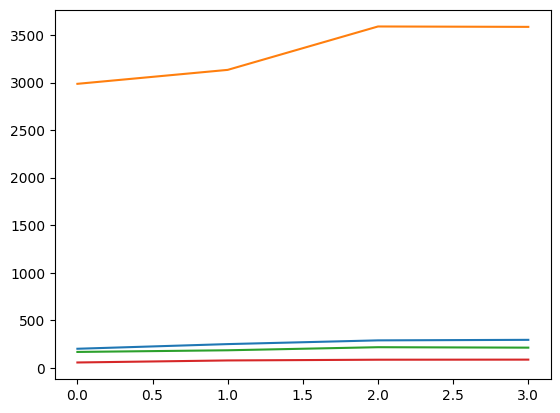

In [17]:
#Dans cette cellule nous comparons les payoff pour une trajectoire de l'actif entre le modèle et la fonction du payoff

model_heston_basket_call = model_heston["model_heston_basket_call"]
model_heston_digital_option = model_heston["model_heston_digital_option"]
model_heston_worst_of_put = model_heston["model_heston_worst_of_put"]
model_heston_asian_option = model_heston["model_heston_asian_option"]

list_model_heston = [model_heston_basket_call, model_heston_digital_option, model_heston_worst_of_put, model_heston_asian_option]

train(list_model_vol, 'heston', torch.randn(nb_trajectoires, nb_steps+1, d), hyperparameters)

In [18]:
#Testons maintenant la méthode 2 avec Black Scholes
#Nous comparons les payoff obtenus pour une trajectoire de l'actif avec le modèle et avec la fonction du payoff

perc_train_set = hyperparameters["perc_train_set"]

random_number = np.random.randint(nb_trajectoires*perc_train_set,nb_trajectoires)

Z = torch.randn(nb_trajectoires, nb_steps+1, d)

print("trajectoire numero " + str(random_number))
random_Z = Z[random_number,: ,:]

random_Z = random_Z.reshape(1, nb_steps+1, d)

random_S = heston_model(S0, K, T, r, kappa, sigma_0, a, nu, gamma, nb_trajectoires, nb_steps, d, rho, random_Z)

#Evaluation du payoff de la trajectoire avec les fonctions payoff
print("Payoff Call Basket | output : ", basket_call_payoff(random_S, weights, K).item())
print("Payoff Digital Option | output : ", digital_option_payoff(random_S, weights, K).item())
print("Payoff Put Worst of max | output : ", worst_of_put_payoff(random_S, weights, K).item())
print("Payoff Arithmetic Asian | output : ", asian_option_payoff(random_S, weights, K).item())

print()
random_Z = random_Z.reshape(1, -1)
random_Z = random_Z.to(device)

#Evaluation du payoff de la trajectoire avec les modèles
for model_name, model_instance in model_heston.items():
    model_instance.eval()
    output = model_instance(random_Z).item()
    print(f"Model {model_name} | output : ", output)

trajectoire numero 26893
Payoff Call Basket | output :  0.0
Payoff Digital Option | output :  0.0
Payoff Put Worst of max | output :  25.269079208374023
Payoff Arithmetic Asian | output :  0.0

Model model_heston_basket_call | output :  0.13476485013961792
Model model_heston_digital_option | output :  0.17114663124084473
Model model_heston_worst_of_put | output :  -0.207601398229599
Model model_heston_asian_option | output :  -0.3185952305793762


In [19]:
dic_model_heston_payoff = {model_heston_basket_call : basket_call_payoff, model_heston_digital_option : digital_option_payoff,
                     model_heston_worst_of_put : worst_of_put_payoff, model_heston_asian_option : asian_option_payoff}

new_Z = torch.randn(nb_trajectoires, nb_steps+1, d)

#Prix proches de ceux du tableau 6    
for model,payoff in dic_model_heston_payoff.items():
  Y(model,'heston', payoff,new_Z)

9.652969
54.602016
12.1644535
4.943625


### Dimension reduction

In [36]:
#not functionnal, needs a new design

class DimensionReductionNetwork(nn.Module):
  def __init__(self, input_dim, reduction_dim, output_dim):
    super(DimensionReductionNetwork, self).__init__()
    self.reduction_layer = nn.Linear(input_dim, reduction_dim, bias=False)
    self.reconstitution_layer = nn.Linear(reduction_dim, output_dim)

  def forward(self, x):
    z_tilde = self.reduction_layer(x)
    reconstructed_output = self.reconstitution_layer(torch.relu(z_tilde))
    return z_tilde

In [37]:
N = d

hyperparameters = {"prop_train_set" : 0.8, "input_size" : (nb_steps+1)*d
                              , "reduction_dim" : 100, "output_dim" : 1, "batch_size" : 32
                             , "nb_epochs" : 300, "lr" : 0.01}

In [38]:
input_size = hyperparameters["input_size"]
reduction_dim = hyperparameters["reduction_dim"]
output_dim = hyperparameters["output_dim"]

model_basket_call_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_digital_option_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_worst_of_put_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)
model_asian_option_dim = DimensionReductionNetwork(input_size, reduction_dim, output_dim)

model_basket_call_dim.to(device)
model_digital_option_dim.to(device)
model_worst_of_put_dim.to(device)
model_asian_option_dim.to(device)

list_model = [model_basket_call_dim, model_digital_option_dim, model_worst_of_put_dim, model_asian_option_dim]

S = black_scholes_model(S0, K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, torch.randn(nb_trajectoires, nb_steps+1, d))

Z = torch.randn(nb_trajectoires, nb_steps+1, d)
Propotion_X_train = int(hyperparameters["prop_train_set"]*Z.shape[0])
X_train = Z[:Propotion_X_train,:,:]
X_test = Z[Propotion_X_train:,:,:]
S_train = black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X_train)
S_test = black_scholes_model(S0 , K, T, r, sigma, nb_trajectoires, nb_steps, d, rho, X_test)
y_train = basket_call_payoff(S_train, weights, K)
y_test = basket_call_payoff(S_test, weights, K)

X_train = X_train.view(X_train.shape[0], -1)
y_train = y_train.view(y_train.shape[0], 1)

X_test = X_test.view(X_test.shape[0], -1)
y_test = y_test.view(y_test.shape[0], 1)

#Entrainement du modèle
def train(model, hyperparameters):

    
    nb_epochs = hyperparameters["nb_epochs"]
    lr = hyperparameters["lr"]
    
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr)
    
    for epoch in tqdm(range(nb_epochs)):
        model.train()

        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        model_basket_call_dim.eval()
        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

In [39]:
train(model_basket_call_dim, hyperparameters)

  0%|▎                                                                                 | 1/300 [00:00<01:26,  3.45it/s]

Epoch: 0 | Loss: 967.9834594726562 | Test loss: 1014.2572631835938


  4%|██▉                                                                              | 11/300 [00:03<01:32,  3.12it/s]

Epoch: 10 | Loss: 883.24365234375 | Test loss: 940.865478515625


  7%|█████▋                                                                           | 21/300 [00:06<01:20,  3.47it/s]

Epoch: 20 | Loss: 817.3955688476562 | Test loss: 883.6741333007812


 10%|████████▎                                                                        | 31/300 [00:09<01:24,  3.19it/s]

Epoch: 30 | Loss: 765.8811645507812 | Test loss: 838.0845947265625


 14%|███████████                                                                      | 41/300 [00:12<01:17,  3.35it/s]

Epoch: 40 | Loss: 724.618896484375 | Test loss: 800.4120483398438


 17%|█████████████▊                                                                   | 51/300 [00:17<02:06,  1.96it/s]

Epoch: 50 | Loss: 690.6276245117188 | Test loss: 767.9284057617188


 20%|████████████████▍                                                                | 61/300 [00:20<01:05,  3.67it/s]

Epoch: 60 | Loss: 661.9307861328125 | Test loss: 739.1862182617188


 24%|███████████████████▏                                                             | 71/300 [00:24<01:29,  2.55it/s]

Epoch: 70 | Loss: 637.2717895507812 | Test loss: 713.5443115234375


 27%|█████████████████████▊                                                           | 81/300 [00:27<01:05,  3.33it/s]

Epoch: 80 | Loss: 615.8305053710938 | Test loss: 690.7103881835938


 30%|████████████████████████▌                                                        | 91/300 [00:32<01:39,  2.09it/s]

Epoch: 90 | Loss: 597.0462646484375 | Test loss: 670.3910522460938


 34%|██████████████████████████▉                                                     | 101/300 [00:36<01:37,  2.05it/s]

Epoch: 100 | Loss: 580.5189819335938 | Test loss: 652.3162231445312


 37%|█████████████████████████████▌                                                  | 111/300 [00:40<01:16,  2.48it/s]

Epoch: 110 | Loss: 565.9500732421875 | Test loss: 636.2540283203125


 40%|████████████████████████████████▎                                               | 121/300 [00:43<00:53,  3.38it/s]

Epoch: 120 | Loss: 553.1058959960938 | Test loss: 622.0115356445312


 44%|██████████████████████████████████▉                                             | 131/300 [00:49<02:01,  1.39it/s]

Epoch: 130 | Loss: 541.795654296875 | Test loss: 609.4154663085938


 47%|█████████████████████████████████████▌                                          | 141/300 [00:54<00:56,  2.82it/s]

Epoch: 140 | Loss: 531.8571166992188 | Test loss: 598.309326171875


 50%|████████████████████████████████████████▎                                       | 151/300 [00:57<00:43,  3.46it/s]

Epoch: 150 | Loss: 523.1483764648438 | Test loss: 588.5526733398438


 54%|██████████████████████████████████████████▉                                     | 161/300 [01:01<01:07,  2.06it/s]

Epoch: 160 | Loss: 515.5423583984375 | Test loss: 580.0135498046875


 57%|█████████████████████████████████████████████▌                                  | 171/300 [01:04<00:34,  3.74it/s]

Epoch: 170 | Loss: 508.923828125 | Test loss: 572.5685424804688


 60%|████████████████████████████████████████████████▎                               | 181/300 [01:07<00:35,  3.34it/s]

Epoch: 180 | Loss: 503.18731689453125 | Test loss: 566.1043701171875


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:12<00:50,  2.15it/s]

Epoch: 190 | Loss: 498.2357482910156 | Test loss: 560.5169677734375


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:14<00:26,  3.74it/s]

Epoch: 200 | Loss: 493.9801025390625 | Test loss: 555.7098388671875


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:19<00:41,  2.17it/s]

Epoch: 210 | Loss: 490.33843994140625 | Test loss: 551.5939331054688


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:22<00:30,  2.55it/s]

Epoch: 220 | Loss: 487.2360534667969 | Test loss: 548.0872802734375


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:27<00:32,  2.12it/s]

Epoch: 230 | Loss: 484.60479736328125 | Test loss: 545.1145629882812


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:30<00:20,  2.91it/s]

Epoch: 240 | Loss: 482.3831481933594 | Test loss: 542.6077880859375


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:36<00:25,  1.95it/s]

Epoch: 250 | Loss: 480.5157470703125 | Test loss: 540.5051879882812


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:39<00:16,  2.31it/s]

Epoch: 260 | Loss: 478.9529724121094 | Test loss: 538.751220703125


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:44<00:11,  2.62it/s]

Epoch: 270 | Loss: 477.6510009765625 | Test loss: 537.2964477539062


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:50<00:13,  1.43it/s]

Epoch: 280 | Loss: 476.57110595703125 | Test loss: 536.096923828125


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:53<00:02,  3.22it/s]

Epoch: 290 | Loss: 475.6793212890625 | Test loss: 535.114013671875


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:58<00:00,  2.54it/s]


In [ ]:
# Obtenir la matrice U normalisée

Z = torch.randn(nb_trajectoires, N)

#def basisKernel(U):
    n, N = U.shape
    I = torch.eye(N)
    matrice_augmentee = torch.cat((U, I), dim=0)
    matrice_augmentee = Matrix(matrice_augmentee)
    return matrice_augmentee.nullspace()

list_model = [model_basket_call_dim]

for model in list_model:
    U_normalisee = model.reduction_layer.weight.data / torch.norm(model.reduction_layer.weight.data, dim=1, keepdim=True)
    V = basisKernel(U_normalisee)
    print("V", V)
    print("V DIM : ", len(V))
    print("U_normalisee", U_normalisee.T.shape)
    #Erreur on devrait trouver V de dimension N-n*N
    Z_reduit = torch.matmul(Z, U_normalisee.T)

    # Simulation de Z_orthogonal
    Z_orthogonal = torch.matmul(Z, V.T)
    M=torch.cat((U_normalisee, V), dim=0)
print(V.shape)
print(U_normalisee.shape)